In [1]:
import re
import time
import json
import numpy as np
import pandas as pd
from inc_ms_fda import IncFDO
from prog_ms_fda import ProgressiveFDA
import matplotlib.pyplot as plt

## Read Dataset

In [2]:
df = pd.read_csv("./sample_data.csv")
df.head()

,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,...,C_991,C_992,C_993,C_994,C_995,C_996,C_997,C_998,C_999,cluster
0,-2.501549,-0.640244,-0.617082,0.299425,1.857512,0.088754,-1.252648,-1.420643,-1.696234,-0.171262,...,-0.430874,-0.623891,-0.991095,-0.110948,-0.966542,0.973622,1.634389,-0.335547,1.177089,magenta
1,-2.516121,-0.642003,-0.555533,0.335831,1.889380,0.230216,-1.294657,-1.282850,-1.760500,-0.191101,...,-0.459725,-0.595103,-1.050591,-0.019635,-0.921051,1.043187,1.585560,-0.273158,1.052465,magenta
2,-2.501005,-0.449770,-0.524506,0.314641,2.007789,0.196037,-1.298279,-1.241967,-1.779081,-0.283701,...,-0.431125,-0.484368,-0.973948,0.011635,-0.819877,1.085361,1.621825,-0.281059,1.054436,magenta
3,-2.530243,-0.454835,-0.486073,0.211770,2.093263,0.250556,-1.291069,-1.246917,-1.839455,-0.387017,...,-0.477212,-0.524701,-1.064433,0.042679,-0.719382,1.179833,1.512871,-0.227947,1.139464,magenta
4,-2.573779,-0.497773,-0.489053,0.184279,2.127997,0.300111,-1.173739,-1.226838,-1.839536,-0.330385,...,-0.472353,-0.362096,-1.037222,-0.023874,-0.778937,1.134735,1.404128,-0.257197,1.166177,magenta


<Figure size 1800x360 with 0 Axes>

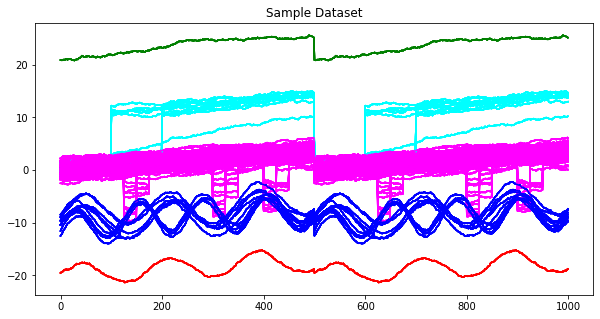

In [3]:
plt.figure(figsize=(25,5))
colors = df.cluster.tolist()
df.iloc[:,:-1].plot(legend=None, color=colors, figsize=(10,5))
plt.title("Sample Dataset")
plt.show()

## Magnitude Shape Plot

(1000,)


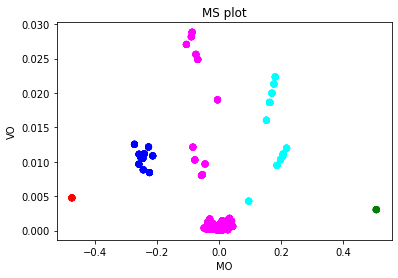

In [5]:

inc_fdo1 = IncFDO()
ts = df.iloc[:,:-1].T.to_numpy()
inc_fdo1.initial_fit(ts)

#The colors of follow the clustering of the sample dataset
plt.scatter(x=inc_fdo1.MO, y =inc_fdo1.VO, c=colors)
plt.title("MS plot")
plt.xlabel("MO")
plt.ylabel("VO")
plt.show()

## Progressive MS with and without Approximation

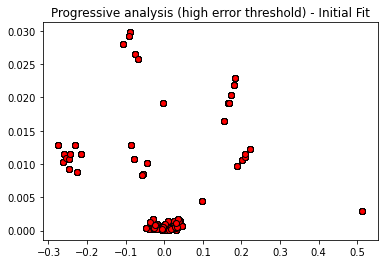

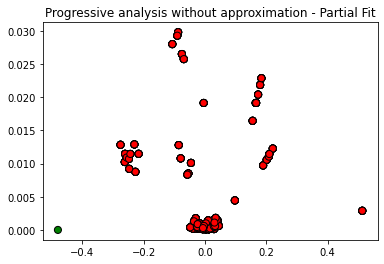

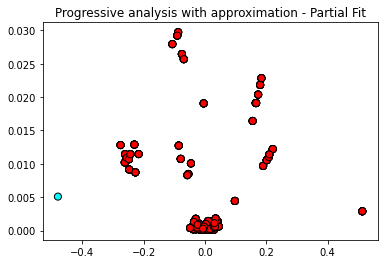

In [13]:
# get index of red cluster
red_col_indx = df[df.cluster == 'red'].index.tolist()
red_col_indx_not = [i for i in range(ts.shape[0]) if i not in red_col_indx]

tsSM_first = ts[red_col_indx_not,:]
tsSM_prog = ts[red_col_indx,:]

prg_fda = ProgressiveFDA(threshold=10)
prg_fda.initial_fit(tsSM_first)
lis_ini = np.vstack((prg_fda.MO, prg_fda.VO)).T

plt.scatter(lis_ini[:,0], lis_ini[:,1], c="red", edgecolors='black')
plt.title("Progressive analysis (high error threshold) - Initial Fit")
plt.show()


x_new = tsSM_prog[0,:]
prg_fda.partial_fit(x_new)

lis_par = np.vstack((prg_fda.MO, prg_fda.VO)).T
cl = ['red'] * len(red_col_indx_not) + ['green']
plt.scatter(lis_par[:,0], lis_par[:,1], c=cl, edgecolors='black', s=50)
plt.title("Progressive analysis without approximation - Partial Fit")
plt.show()

prg_fda = ProgressiveFDA(threshold=1)
prg_fda.initial_fit(tsSM_first)
lis_ini = np.vstack((prg_fda.MO, prg_fda.VO)).T

x_new = tsSM_prog[0,:]
prg_fda.partial_fit(x_new)

#new time series is slightly higher than its original position

lis_par = np.vstack((prg_fda.MO, prg_fda.VO)).T
cl = ['red'] * (len(red_col_indx_not)) +['cyan']
plt.scatter(lis_par[:,0], lis_par[:,1], c=cl, edgecolors='black', s=50)
plt.title("Progressive analysis with approximation - Partial Fit")
plt.show()

In [39]:
## Incremental and Progressive Completion Times

In [33]:
result_dict = {"MS":[], "Inc-MS":[]}

#creating larger sample set for analysis
n = 20000
n1 = (n//df.shape[0])+1
n2 = (n//df.shape[1])+1
ts_ = np.hstack([ts for i in range(n1)])[:n,:n]
ts_new = np.vstack([ts_ for i in range(n2)])[:n,:n]
dataSize = [500, 1000, 2000, 5000, 10000, 19999]
for d_size in dataSize:#[20000, 40000,50000,60000]:

    n = d_size

    ts_m = ts_new[:n,:n]
    ts_prg = ts_new[:n-1,:n]
    ts_prg_add = ts_new[n-1,:n]
    print("ts_m shape",ts_m.shape)

    first = int(d_size *(5/100)) # 5% of the data for initial processing
    test_set_inc = ts_m[:,:first]

    #MagnitudeShapePlot
    start = time.process_time()
    inc_fdo1 = IncFDO()
    inc_fdo1.initial_fit(ts_m)
    end = time.process_time() - start
    result_dict["MS"].append(end)
    print("Overall MS for data size {} completed in {} ".format(d_size, end))


    #inc MagnitudeShapePlot
    start = time.process_time()
    inc_fdo = IncFDO()
    inc_fdo.initial_fit(test_set_inc) #using 5% of data for initial processing
    print("first,n", first,n)
    for i in range(first,n):
        inc_fdo.partial_fit(ts_m[:,i]) # adding the rest of the timepoints incrementally
    end = time.process_time() - start
    result_dict["Inc-MS"].append(end)
    print("Inc-MS for data size {} completed in {} ".format(d_size, end))
    
    #progressive MagnitudeShapePlot
    prg_fda = ProgressiveFDA(threshold=10)
    start = time.process_time()
    prg_fda.initial_fit(ts_prg)
    end = time.process_time() - start
    print("Prg-MS (Inital fit) for data size {} completed in {} ".format(d_size, end))
    lis_ini = np.vstack((prg_fda.MO, prg_fda.VO)).T

    #below we do not perform check for approximation and the approximated results are computed
    #The actual results can then be computed in the background and made available to the user 
    #after completion
    print("Initial fit ", lis_ini.shape)
    for k in range(1):
        #x_new = np.squeeze(ts_new[:, k:k+1])
        start = time.process_time()
        prg_fda.partial_fit(ts_prg_add, approximate=False)
        end = time.process_time() - start
        print("Prg-MS (partial fit - adding 1 timeseries) for data size {} completed in {}".format(d_size, end))
        lis_par = np.vstack((prg_fda.MO, prg_fda.VO)).T

    print('\n')

ts_m shape (500, 500)
(500,)
Overall MS for data size 500 completed in 0.013928999999961889 
(25,)
first,n 25 500
Inc-MS for data size 500 completed in 0.0811390000000074 
Prg-MS (Inital fit) for data size 500 completed in 0.010565999999982978 
Initial fit  (499, 2)
Prg-MS (partial fit - adding 1 timeseries) for data size 500 completed in 0.0006839999999783686


ts_m shape (1000, 1000)
(1000,)
Overall MS for data size 1000 completed in 0.05388799999997218 
(50,)
first,n 50 1000
Inc-MS for data size 1000 completed in 0.1628690000000006 
Prg-MS (Inital fit) for data size 1000 completed in 0.04078199999997878 
Initial fit  (999, 2)
Prg-MS (partial fit - adding 1 timeseries) for data size 1000 completed in 0.0018220000000042091


ts_m shape (2000, 2000)
(2000,)
Overall MS for data size 2000 completed in 0.5748609999999985 
(100,)
first,n 100 2000
Inc-MS for data size 2000 completed in 0.4254030000000171 
Prg-MS (Inital fit) for data size 2000 completed in 0.19798800000000938 
Initial fit  

<Figure size 720x360 with 0 Axes>

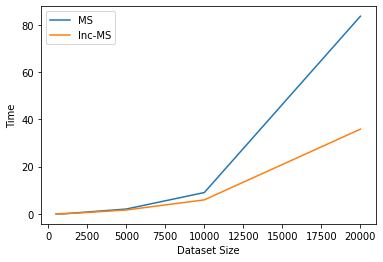

In [38]:
dfP = pd.DataFrame(result_dict)
dfP['dsize'] = [500, 1000, 2000, 5000, 10000, 19999]
dfP.set_index('dsize', inplace=True)
plt.figure(figsize=(10,5))
dfP.plot()
plt.xlabel("Dataset Size")
plt.ylabel("Time")
plt.show()